# NN on plane sums

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'projection')

X_train, y_train, _, _ = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 13)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
#min_clip = 500
#X_train_clp, y_train_clp = operate_datasets.clip_dataset(X_train, y_train, min_clip)
X_train_clp, y_train_clp = X_train, y_train

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints

#import pyro
#import pyro.distributions as dist
#from pyro.nn import PyroModule

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
X_tens = torch.tensor(X_train_clp).float()
y_tens = torch.tensor(y_train_clp).float()

In [9]:
X_tens.shape

torch.Size([108000, 13])

In [10]:
def train_iteration(model, optimizer, loss_fn, x_data, y_data):
    y_pred = model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
class NN(nn.Module):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, 1)

    def forward(self, x, y=None):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [116]:
def run_training(num_iter):
    model = NN(X_tens[0].shape[0], 32) # PyroModule[nn.Linear](1, 1)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    loss_arr  = []

    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = ReduceLROnPlateau(optim, 'min', factor=0.5, patience=25, verbose=True, threshold=1e-2)

    for j in range(num_iter):
        loss = train_iteration(model, optim, loss_fn, X_tens, y_tens)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
            
        scheduler.step(loss)
        loss_arr.append(loss.item())
        
    return model, loss_arr

In [129]:
model, loss_arr = run_training(1000)

[iteration 0050] loss: 19094.6387
[iteration 0100] loss: 4324.9883
[iteration 0150] loss: 3714.4116
[iteration 0200] loss: 3363.2834
[iteration 0250] loss: 3151.4829
[iteration 0300] loss: 3017.5979
[iteration 0350] loss: 2920.6265
[iteration 0400] loss: 2846.7534
[iteration 0450] loss: 2786.8293
Epoch   478: reducing learning rate of group 0 to 5.0000e-03.
[iteration 0500] loss: 2746.8625
Epoch   506: reducing learning rate of group 0 to 2.5000e-03.
Epoch   532: reducing learning rate of group 0 to 1.2500e-03.
[iteration 0550] loss: 2735.5754
Epoch   558: reducing learning rate of group 0 to 6.2500e-04.
Epoch   584: reducing learning rate of group 0 to 3.1250e-04.
[iteration 0600] loss: 2732.5112
Epoch   610: reducing learning rate of group 0 to 1.5625e-04.
Epoch   636: reducing learning rate of group 0 to 7.8125e-05.
[iteration 0650] loss: 2731.6594
Epoch   662: reducing learning rate of group 0 to 3.9063e-05.
Epoch   688: reducing learning rate of group 0 to 1.9531e-05.
[iteration 0

In [130]:
y_pred = model(torch.Tensor(X_train)).detach().cpu().numpy().squeeze(-1)

In [131]:
y_pred

array([0.36698705, 0.1267043 , 0.44502312, ..., 0.26119643, 0.24386032,
       0.2661077 ], dtype=float32)

## Visualise results

In [132]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [133]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [134]:
model_name = 'NN on plane sums'
save_file_prefix = model_name.replace(' ', '-')

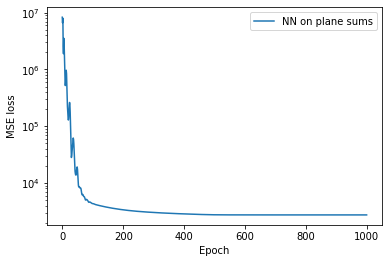

In [135]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

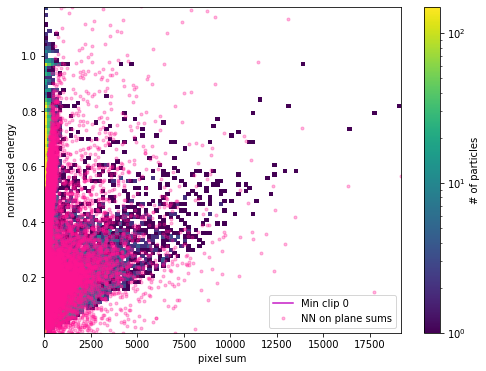

In [136]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

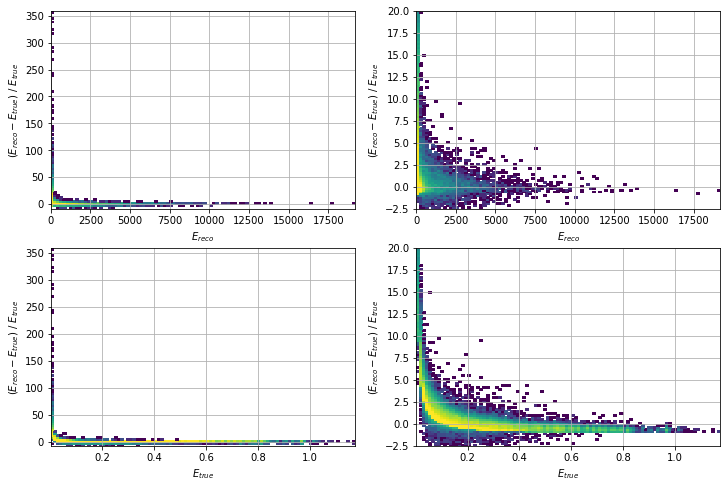

In [137]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.42653e+00
std    = 5.39071e+00
median = 2.80571e-01


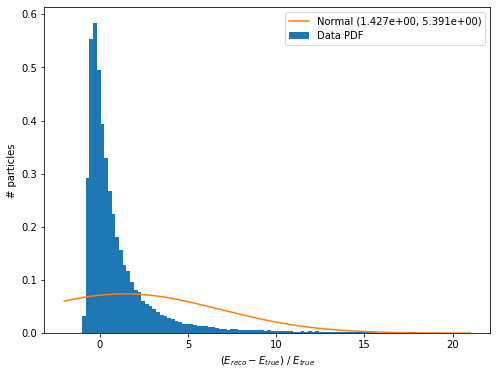

In [138]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [139]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score 0.20950362021802005
max_error 2.3874049613466037
mean_absolute_error 0.11577744989053665
mean_squared_error 0.025290177750331582
median_absolute_error 0.09203340980046304
r2_score 0.20950278500788722


,NN-on-plane-sums
explained_variance_score,0.209504
max_error,2.387405
mean_absolute_error,0.115777
mean_squared_error,0.025290
median_absolute_error,0.092033
r2_score,0.209503
avg_resolution,1.426525
std_resolution,5.390709


In [140]:
model_evaluation.collect_all_scores()

,Score,L2-on-projections,L2-regression-(clip),NN-on-sum,L2-on-plane-sums,NN-on-plane-sums,L2-on-true-hits
0,explained_variance_score,0.050684,0.014135,0.020719,0.279462,0.209504,0.127250
1,max_error,0.977129,1.003849,1.044819,1.035705,2.387405,0.999070
2,mean_absolute_error,0.129588,0.130024,0.126946,0.113108,0.115777,0.125568
3,mean_squared_error,0.029965,0.032028,0.033186,0.023052,0.025290,0.027922
4,median_absolute_error,0.110256,0.104099,0.092175,0.092548,0.092033,0.107848
5,r2_score,0.050683,-0.001109,-0.037294,0.279462,0.209503,0.127250
6,avg_resolution,2.009617,1.729036,1.320563,1.498581,1.426525,1.872374
7,std_resolution,7.685008,7.130151,5.642022,5.833365,5.390709,7.319886
